<a href="https://colab.research.google.com/github/victorhuangkk/york_math6650/blob/main/sequential_data_and_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal

**This problem is formulated as a time-series analysis problem. In this problem we adopt both the univariate sequential model in tensorflow, and multivariate deep-learning based approach (LSTM) and compare their performance.**


1.   Data Source: I used yahoo finance to fetch real data
2.   Development: I used pure Python with a few open source frameworks to accomplish this task
3.   Amazon has been used as an example, feel free to use any other stocks in the pipeline to test the code



In [ ]:
!pip install yfinance

     |████████████████████████████████| 5.5MB 7.6MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.55-py2.py3-none-any.whl size=22616 sha256=ae09d9ab02ce517b4681ad7ce4bb983c0a8fee57014b89fdb01f3277fbff92c1
  Stored in directory: /root/.cache/pip/wheels/04/98/cc/2702a4242d60bdc14f48b4557c427ded1fe92aedf257d4565c
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [ ]:
import pandas as pd
import tensorflow as tf
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import os
import random
import yfinance as yf
import plotly.graph_objects as go
from datetime import datetime
import numpy as np

In [ ]:
# feel free to change this ticker to any other valid equity. 
tickerData = yf.Ticker('AMZN')

#get the historical prices for this ticker
tickerDf = tickerData.history(start='2010-1-1', period="max",
                              end=datetime.today().strftime('%Y-%m-%d'), auto_adjust = True)

In [ ]:
tickerDf.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2010-01-04,136.250000,136.610001,133.139999,133.899994,7599900,0,0
2010-01-05,133.429993,135.479996,131.809998,134.690002,8851900,0,0
2010-01-06,134.600006,134.729996,131.649994,132.250000,7178800,0,0
2010-01-07,132.009995,132.320007,128.800003,130.000000,11030200,0,0
2010-01-08,130.559998,133.679993,129.029999,133.520004,9830500,0,0


The Candle stick plot here displays the price over time. To going foward with t

In [ ]:
plot_df = tickerDf.reset_index()

fig = go.Figure(data=[go.Candlestick(x=plot_df.Date,
                open=plot_df.Open, high=plot_df.High,
                low=plot_df.Low, close=plot_df.Close)])

fig.update_layout(xaxis_rangeslider_visible=True)
fig.show()

# Single Sequence with TensorFlow LSTM


In [ ]:
# In time series analysis, stock price maybe better analyzed via percent of change rather than the actual equity price

pct_df = tickerDf.pct_change()
df = pct_df[pct_df.index >= '2010-01-05'][['Open','High', 'Close', 'Low', 'Volume']]

In [ ]:
df.head()

,Open,High,Close,Low,Volume
Date,,,,,
2010-01-05,-0.020697,-0.008272,0.005900,-0.009989,0.164739
2010-01-06,0.008769,-0.005536,-0.018116,-0.001214,-0.189010
2010-01-07,-0.019242,-0.017888,-0.017013,-0.021648,0.536496
2010-01-08,-0.010984,0.010278,0.027077,0.001786,-0.108765
2010-01-11,0.015778,-0.006583,-0.024041,0.001395,-0.106922


In [ ]:
window_size = 30
train_size = 2000

train_data=df.iloc[:(train_size+window_size), 0:1]
train_data.shape

(2030, 1)

In [ ]:
#preprocess data using Minmax sclaer
scaler=preprocessing.MinMaxScaler()
train_data_transform=scaler.fit_transform(np.array(train_data))

x_train,y_train=[],[]
for i in range(len(train_data_transform)-window_size):
    x_train.append(train_data_transform[i:i+window_size])
    y_train.append(train_data_transform[i+window_size])

x_train=np.array(x_train)

y_train=np.array(y_train)
cnow, ncol = y_train.shape

In [ ]:
model=tf.keras.models.Sequential(
    [tf.keras.layers.LSTM(100,return_sequences=True,input_shape=(x_train.shape[1], x_train.shape[2])),
     tf.keras.layers.Dropout(0.3),
     tf.keras.layers.LSTM(50,return_sequences=True),
     tf.keras.layers.Dropout(0.2),
     tf.keras.layers.LSTM(50),
     tf.keras.layers.Dropout(0.2),
     tf.keras.layers.Dense(1)
    ])

model.summary()
model.compile(optimizer='adam', loss='mean_squared_error',metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 100)           40800     
_________________________________________________________________
dropout (Dropout)            (None, 30, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 50)            30200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 5

In [ ]:
model.fit(x_train, y_train, epochs=13, batch_size=40)

Epoch 1/13
50/50 [==============================] - 7s 56ms/step - loss: 0.0556 - accuracy: 0.0011
Epoch 2/13
50/50 [==============================] - 3s 55ms/step - loss: 0.0058 - accuracy: 7.1804e-05
Epoch 3/13
50/50 [==============================] - 3s 55ms/step - loss: 0.0059 - accuracy: 0.0000e+00
Epoch 4/13
50/50 [==============================] - 3s 56ms/step - loss: 0.0059 - accuracy: 5.2924e-04
Epoch 5/13
50/50 [==============================] - 3s 55ms/step - loss: 0.0057 - accuracy: 2.1098e-04
Epoch 6/13
50/50 [==============================] - 3s 57ms/step - loss: 0.0056 - accuracy: 0.0000e+00
Epoch 7/13
50/50 [==============================] - 3s 56ms/step - loss: 0.0054 - accuracy: 8.2855e-04
Epoch 8/13
50/50 [==============================] - 3s 54ms/step - loss: 0.0050 - accuracy: 7.3496e-04
Epoch 9/13
50/50 [==============================] - 3s 56ms/step - loss: 0.0045 - accuracy: 4.6771e-04
Epoch 10/13
50/50 [==============================] - 3s 57ms/step - loss: 0.0

In [ ]:
train_data = df.iloc[ :int(train_size)]
test_data = df.iloc[int(train_size): ]
        
data = pd.concat((train_data['Open'], test_data['Open']), axis=0)

test_input_shape = data[len(train_data) - window_size: ].values
test_input_shape = test_input_shape.reshape(-1,1)
test_input_shape = scaler.transform(test_input_shape)
        
X_test = []
        
for i in range(window_size, len(test_data)+window_size): 
    X_test.append(test_input_shape[i-window_size:i, 0])
            
X_test = np.array(X_test)

In [ ]:
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

prediction = model.predict(X_test)

prediction_inverse = scaler.inverse_transform(prediction)

prediction_inverse.shape

(801, 1)

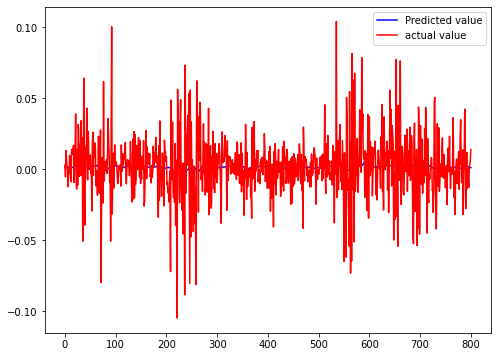

In [ ]:
y_test = df.iloc[int(train_size): ,0:1].values
plt.figure(figsize=(8,6))
plt.plot(prediction_inverse, color='blue', label='Predicted value')
plt.plot(y_test, color ='red', label='actual value')
plt.legend()
plt.show()

In [ ]:
print('Mean Absolute Error: ', mean_absolute_error(y_test, prediction_inverse))
print('Mean Squared Error: ', mean_squared_error(y_test, prediction_inverse))

Mean Absolute Error:  0.015739815165937136
Mean Squared Error:  0.0004980930969888443


This is a keras LSTM demo [image](https://wiki.ubc.ca/images/1/14/Keras-LSTM-tutorial-architecture-642x381.png)


# Multivariates Sequential Pytorch Bayesian LSTM

After working on the uni-variate LSTM model, the second approach I am using is a multi-variate Bayesian LSTM approach. In this approach, I am forecasting the number of trips for the next 30 periods (window size), by implementing the method in this paper: https://arxiv.org/abs/1709.01907

Unlike the univariate LSTM model I used above, this approach may win for two reasons:

1. It not only gives out a point estimation, but also quantifies uncertainty from a Bayesian view. This is valuable information to guide traders' activities. 
2. It uses multi-variates deep learning approach, which not only uses all available features given, also it does not need feature engineering. Also, compared with a HMM (Hidden Markov Model), this approaches enabled us to avoid strong first order assumption 
$P(w_i|w_{i-1})P(w_{i-1}|w_{i-2})P(w_{i-2}|w_{i-3})... = P(w_i, w_{i-1}, w_{i-2}, ...w_1)$

Define Bayesian LSTM Architecture
To demonstrate a simple working example of the Bayesian LSTM, the model as defined in Uber's paper has been used a starting point. The network architecture is as follows:

Encoder-Decoder Stage:

1. 1 uni-directional LSTM layer with 128 hidden units acts as an encoding layer to construct a fixed-dimension embedding state
2. 1 uni-directional LSTM layer with 32 hidden units acts as a decoding layer to produce predictions at future steps
3. Dropout is applied at both training and inference for both LSTM layers

Predictor Stage:

1. 1 fully-connected output layer with 1 output (for predicting the target value) to produce a single value for the target variable

By allowing dropout at both training and testing time, the model simulates random sampling, thus allowing varying predictions that can be used to estimate the underlying distribution of the target value, enabling explicit model uncertainties.

In [ ]:
df.head()

,Open,High,Close,Low,Volume
Date,,,,,
2010-01-05,-0.020697,-0.008272,0.005900,-0.009989,0.164739
2010-01-06,0.008769,-0.005536,-0.018116,-0.001214,-0.189010
2010-01-07,-0.019242,-0.017888,-0.017013,-0.021648,0.536496
2010-01-08,-0.010984,0.010278,0.027077,0.001786,-0.108765
2010-01-11,0.015778,-0.006583,-0.024041,0.001395,-0.106922



# Prepare Training Data
For this example, we will use sliding windows of 10 points per each window (equivalent to 10 days) to predict each next point. The window size can be altered via the sequence_length variable.

Min-Max scaling has also been fitted to the training data to aid the convergence of the neural network.



In [ ]:
from sklearn.preprocessing import MinMaxScaler

def create_sliding_window(data, sequence_length, stride=1):
    X_list, y_list = [], []
    for i in range(len(data)):
      if (i + sequence_length) < len(data):
        X_list.append(data.iloc[i:i+sequence_length:stride, :].values)
        y_list.append(data.iloc[i+sequence_length, -1])
    return np.array(X_list), np.array(y_list)

sequence_length = 30


pct_df_torch = tickerDf[['High', 'Close', 'Low', 'Volume', 'Open']]
train_period = tickerDf[pct_df_torch.index <= "2019-01-05"]
n_train = len(train_period) - sequence_length

n_test = len(pct_df_torch) - n_train
print(n_train, n_test)

features = pct_df_torch.columns

feature_array = pct_df_torch[features].values

# Fit Scaler only on Training features
feature_scaler = MinMaxScaler()
feature_scaler.fit(feature_array[:n_train])
# Fit Scaler only on Training target values
target_scaler = MinMaxScaler()
target_scaler.fit(feature_array[:n_train, -1].reshape(-1, 1))

# Transfom on both Training and Test data
scaled_array = pd.DataFrame(feature_scaler.transform(feature_array),
                            columns=features)


X, y = create_sliding_window(scaled_array, 
                             sequence_length)

X_train = X[:n_train]
y_train = y[:n_train]

X_test = X[n_train:]
y_test = y[n_train:]

2237 565


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class BayesianLSTM(nn.Module):

    def __init__(self, n_features, output_length):

        super(BayesianLSTM, self).__init__()

        self.hidden_size_1 = 128
        self.hidden_size_2 = 32
        self.n_layers = 1 # number of (stacked) LSTM layers

        self.lstm1 = nn.LSTM(n_features, 
                             self.hidden_size_1, 
                             num_layers=1,
                             batch_first=True)
        self.lstm2 = nn.LSTM(self.hidden_size_1,
                             self.hidden_size_2,
                             num_layers=1,
                             batch_first=True)
        
        self.dense = nn.Linear(self.hidden_size_2, output_length)
        self.loss_fn = nn.MSELoss()
        
    def forward(self, x):
        batch_size, seq_len, _ = x.size()

        hidden = self.init_hidden1(batch_size)
        output, _ = self.lstm1(x, hidden)
        output = F.dropout(output, p=0.5, training=True)
        state = self.init_hidden2(batch_size)
        output, state = self.lstm2(output, state)
        output = F.dropout(output, p=0.5, training=True)
        output = self.dense(state[0].squeeze(0))
        
        return output
        
    def init_hidden1(self, batch_size):
        hidden_state = Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size_1))
        cell_state = Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size_1))
        return hidden_state, cell_state
    
    def init_hidden2(self, batch_size):
        hidden_state = Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size_2))
        cell_state = Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size_2))
        return hidden_state, cell_state
    
    def loss(self, pred, truth):
        return self.loss_fn(pred, truth)

    def predict(self, X):
        return self(torch.tensor(X, dtype=torch.float32)).view(-1).detach().numpy()

In [ ]:
n_features = scaled_array.shape[-1]
output_length = 1

bayesian_lstm = BayesianLSTM(n_features=n_features,
                             output_length=output_length)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(bayesian_lstm.parameters(), lr=0.01)

batch_size = 128
n_epochs = 300

In [ ]:
bayesian_lstm.train()

for e in range(1, n_epochs+1):
    for b in range(0,len(X_train),batch_size):
        features = X_train[b:b+batch_size,:,:]
        target = y_train[b:b+batch_size]    

        X_batch = torch.tensor(features,dtype=torch.float32)    
        y_batch = torch.tensor(target,dtype=torch.float32)

        output = bayesian_lstm(X_batch) 
        loss = criterion(output.view(-1), y_batch)  

        loss.backward()
        optimizer.step()        
        optimizer.zero_grad() 

    if e % 10 == 0:
      print('epoch: ', e, 'loss: ', loss.item())

epoch:  10 loss:  0.3104545474052429
epoch:  20 loss:  0.3086490035057068
epoch:  30 loss:  0.2448543906211853
epoch:  40 loss:  0.30361583828926086
epoch:  50 loss:  0.30330339074134827
epoch:  60 loss:  0.30190250277519226
epoch:  70 loss:  0.30715838074684143
epoch:  80 loss:  0.2963576316833496
epoch:  90 loss:  0.1827506422996521
epoch:  100 loss:  0.01286124624311924
epoch:  110 loss:  0.0828404575586319
epoch:  120 loss:  0.012855298817157745
epoch:  130 loss:  0.007160709239542484
epoch:  140 loss:  0.006490199826657772
epoch:  150 loss:  0.004063054919242859
epoch:  160 loss:  0.004373220261186361
epoch:  170 loss:  0.00305191264487803
epoch:  180 loss:  0.0028083494398742914
epoch:  190 loss:  0.0022884865757077932
epoch:  200 loss:  0.006021000444889069
epoch:  210 loss:  0.003681402886286378
epoch:  220 loss:  0.003750468371436
epoch:  230 loss:  0.005755986087024212
epoch:  240 loss:  0.0030244048684835434
epoch:  250 loss:  0.004070835188031197
epoch:  260 loss:  0.002409

In [ ]:
training_predictions = bayesian_lstm.predict(X_train)

In [ ]:
pct_df_torch = pct_df_torch.reset_index()
offset = sequence_length

def inverse_transform(y):
  return target_scaler.inverse_transform(y.reshape(-1, 1))

training_df = pd.DataFrame()
training_df['Date'] = pct_df_torch['Date'].iloc[offset:n_train + offset:1] 
training_predictions = bayesian_lstm.predict(X_train)
training_df['Open'] = inverse_transform(training_predictions)
training_df['source'] = 'Training Prediction'
training_df.head()

,Date,Open,source
30,2010-02-17,280.138794,Training Prediction
31,2010-02-18,279.642120,Training Prediction
32,2010-02-19,279.827545,Training Prediction
33,2010-02-22,279.836060,Training Prediction
34,2010-02-23,280.750000,Training Prediction


In [ ]:
training_truth_df = pd.DataFrame()
training_truth_df['Date'] = training_df['Date']
training_truth_df['Open'] = pct_df_torch['Open'].iloc[offset:n_train + offset:1] 
training_truth_df['source'] = 'True Values'

testing_df = pd.DataFrame()
testing_df['Date'] = pct_df_torch['Date'].iloc[n_train + offset::1] 
testing_predictions = bayesian_lstm.predict(X_test)
testing_df['Open'] = inverse_transform(testing_predictions)
testing_df['source'] = 'Test Prediction'

testing_truth_df = pd.DataFrame()
testing_truth_df['Date'] = testing_df['Date']
testing_truth_df['Open'] = pct_df_torch['Open'].iloc[n_train + offset::1] 
testing_truth_df['source'] = 'True Values'

evaluation = pd.concat([training_df, testing_df,training_truth_df,testing_truth_df], axis=0)

In [ ]:
evaluation.head()

,Date,Open,source
30,2010-02-17,280.138794,Training Prediction
31,2010-02-18,279.642120,Training Prediction
32,2010-02-19,279.827545,Training Prediction
33,2010-02-22,279.836060,Training Prediction
34,2010-02-23,280.750000,Training Prediction


In [ ]:
print('Mean Absolute Error: ', mean_absolute_error(testing_truth_df['Open'], inverse_transform(testing_predictions)))
print('Mean Squared Error: ', mean_squared_error(testing_truth_df['Open'], inverse_transform(testing_predictions)))

Mean Absolute Error:  537.2977758104556
Mean Squared Error:  626284.7208075108


In [ ]:
import plotly.express as px
import plotly

px.line(evaluation.loc[evaluation['Date'].between('2019-02-01', '2019-10-12')],
                 x="Date",
                 y="Open",
                 color="source",
                 title="Open Price vs. Time")